In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
import os
import pandas as pd
from termcolor import colored
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import sys

In [3]:
def print_dict(my_dict):
    for key,val in my_dict.items():
        print(colored(key, 'blue'),val)

In [4]:
def print_nested_dict(my_dict):
    for key,val in my_dict.items():
        print(colored(key, 'blue'))
        for k,v in val.items():
            print(k,v, end="\n\n")

# Boxplot by a single dict

In [5]:
green_diamond = dict(markerfacecolor='g', marker='D')

def simple_boxplot(my_dict, fig_name):
    fig, ax = plt.subplots(figsize=(10, 5), dpi=80)
    ax.boxplot(my_dict.values(), flierprops=green_diamond)
    ax.set_xticklabels(my_dict.keys())
    plt.ylim(-1, 44)
    plt.tight_layout()
    plt.savefig(fig_name+'.png')

# Boxplot gruped by 3

In [6]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

In [14]:
def grouped_3_boxplot(red, blue, mixed, fig_name):
#     print("RED", red, end='\n\n')
#     print("RED values", red.values(), end='\n\n')
#     print("len RED values", len(red.values()), end='\n\n')
    ticks = mixed.keys()

    fig, ax = plt.subplots(figsize=(10, 5), dpi=80)

    bpl = plt.boxplot(red.values(), positions=np.array(range(len(red.values())))*3.0-0.4, sym='', widths=0.3)
    bpr = plt.boxplot(blue.values(), positions=np.array(range(len(blue.values())))*3.0+0.4, sym='', widths=0.3)
    bpc = plt.boxplot(mixed.values(), positions=np.array(range(len(mixed.values())))*3.0, sym='', widths=0.3)

    set_box_color(bpl, '#d95f02') # colors are from http://colorbrewer2.org/
    set_box_color(bpr, '#7570b3')
    set_box_color(bpc, '#1b9e77')

    # draw temporary red and blue lines and use them to create a legend
    plt.plot([], c='#d95f02', label='Red')
    plt.plot([], c='#7570b3', label='Blue')
    plt.plot([], c='#1b9e77', label='Mixed')
    plt.legend(loc=2)

    # plt.xticks(range(0, 300, 5), ticks)
    # plt.xlim(-3, len(ticks)*3)
    plt.ylim(-1, 44)
    plt.xticks(range(0, len(ticks) * 3, 3), ticks)
    plt.xlim(-2, len(ticks)*3)

    ax.set_xticklabels(mixed.keys())
    ax.set_xlabel("Timeout[s]")
    ax.set_ylabel("Completed areas")

    plt.tight_layout()
    plt.savefig(fig_name+'.png')

# Random exp with persistent motion (1.4, 0.9)

In [ ]:
results_folder = os.path.join(os.getcwd(), "random_mixed_exp")

In [ ]:
if not os.path.isdir(results_folder):
    print(colored("Error, results_folder does not exist", 'red'))
else:
    print(colored("OK, "+results_folder+" exists", 'green'))

### Studio generale di tutte le aree

In [ ]:
timeout = -1 
exp_dict = {}

for timeout_folder in natsorted(os.listdir(os.path.join(results_folder))):
    print(colored("\tTimeout folder:", 'blue'),timeout_folder)
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
            timeout = int(param.split("#")[-1]) * 10
            # print("\ttimeoutR:",timeoutR)

    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    completed_areas = np.array([])
    for filename in os.listdir(os.path.join(results_folder, timeout_folder)):
        if filename.endswith("taskLOG_client.tsv"):
#                 print("\t\tFilename:",filename)
            if not os.path.getsize(os.path.join(results_folder, timeout_folder, filename)) > 0:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                completed_areas = np.append(completed_areas, 0)
                continue

#                 print("\tPath:", os.path.join(results_folder, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder, timeout_folder, filename), sep="\t", header=None)
            completed_areas = np.append(completed_areas, df.shape[0])

    exp_dict[timeout] = completed_areas

In [ ]:
print_dict(exp_dict)

In [ ]:
simple_boxplot(exp_dict, 'random_mixed_exp')

### Studio per ogni tipo di area

In [ ]:
timeout = -1

red_dict = {}
blue_dict = {}
mixed_dict = {}

for timeout_folder in natsorted(os.listdir(os.path.join(results_folder))):
    
    print(colored("\n\nTimeout folder:"+timeout_folder, 'green'))
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
            timeout = int(param.split("#")[-1]) * 10
            # print("\ttimeout:",timeout)

    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    red_array = np.array([])
    blue_array = np.array([])
    mixed_array = np.array([])
    completed_client = np.array([])
    completed_server = np.array([])
    for filename in natsorted(os.listdir(os.path.join(results_folder, timeout_folder))):
        if filename.endswith("taskLOG_client.tsv"):
            print("\tFilename:",filename)
            empty_c = not os.path.getsize(os.path.join(results_folder, timeout_folder, filename)) > 0
            if empty_c:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                red_array = np.append(red_array, 0)
                blue_array = np.append(blue_array, 0)
                mixed_array = np.append(mixed_array, 0)
                continue

#                 print("\tPath:", os.path.join(results_folder, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder, timeout_folder, filename), sep="\t", header=None)
            df.columns =['Completed_t', 'ID', 'Creation_t', 'Completed_t', 'Type', 'Contained']
            completed_client = df.loc[:,"Type"].values
#             print(df)
            print("completed_client: ", completed_client)
            
            
        if filename.endswith("taskLOG_server.tsv"):
            print("\tFilename:",filename)
            empty_s = not os.path.getsize(os.path.join(results_folder, timeout_folder, filename)) > 0
            if not empty_c and empty_s:
                sys.exit("ERROR!!!! client not empty, while empty server file at:" + filename)
            if empty_s:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                continue

#                 print("\tPath:", os.path.join(results_folder, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder, timeout_folder, filename), sep="\t", header=None)
            df.columns =['Completed_t', 'ID', 'Creation_t', 'Completed_t', 'Type', 'Contained']
            completed_server = df.loc[:,"Type"].values
            
#             print(df)
            print("completed_server: ",completed_server)
            
            
#             break
            
            red_sum = np.sum((completed_server==1) & (completed_client==1))
            blue_sum = np.sum((completed_server==0) & (completed_client==0))
            mixed_sum = np.sum((completed_server==0) & (completed_client==1)) + np.sum((completed_server==1) & (completed_client==0))
            print(colored("red_sum", 'red'), red_sum)
            print(colored("blue_sum", 'blue'), blue_sum)
            print(colored("mixed_sum", 'green'), mixed_sum)
            red_array = np.append(red_array, red_sum)
            blue_array = np.append(blue_array, blue_sum)
            mixed_array = np.append(mixed_array, mixed_sum)

    red_dict[timeout] = red_array
    blue_dict[timeout] = blue_array
    mixed_dict[timeout] = mixed_array
#     break  #evaluate just one folder

In [ ]:
grouped_3_boxplot(red_dict, blue_dict, mixed_dict, 'boxcompare_random_mixed')

# Random exp with brownian motion (2.0, 0.0)

In [ ]:
results_folder_brownian = os.path.join(os.getcwd(), "results_brownian/random_mixed_exp")

In [ ]:
if not os.path.isdir(results_folder_brownian):
    print(colored("Error, results_folder_brownian does not exist", 'red'))
else:
    print(colored("OK, "+results_folder_brownian+" exists", 'green'))

### Studio generale di tutte le aree

In [ ]:
timeout = -1 
exp_dict_brownian = {}

for timeout_folder in natsorted(os.listdir(os.path.join(results_folder_brownian))):
    print(colored("\tTimeout folder:", 'blue'),timeout_folder)
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
            timeout = int(param.split("#")[-1]) * 10
            # print("\ttimeoutR:",timeoutR)

    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    completed_areas = np.array([])
    for filename in os.listdir(os.path.join(results_folder_brownian, timeout_folder)):
        if filename.endswith("taskLOG_client.tsv"):
#                 print("\t\tFilename:",filename)
            if not os.path.getsize(os.path.join(results_folder_brownian, timeout_folder, filename)) > 0:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                completed_areas = np.append(completed_areas, 0)
                continue

#                 print("\tPath:", os.path.join(results_folder_brownian, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_brownian, timeout_folder, filename), sep="\t", header=None)
            completed_areas = np.append(completed_areas, df.shape[0])

    exp_dict_brownian[timeout] = completed_areas

In [ ]:
simple_boxplot(exp_dict_brownian, 'random_mixed_brownian_exp')

### Studio per ogni tipo di area

In [ ]:
timeout = -1

red_dict = {}
blue_dict = {}
mixed_dict = {}

for timeout_folder in natsorted(os.listdir(os.path.join(results_folder_brownian))):
    
    print(colored("\n\nTimeout folder:"+timeout_folder, 'green'))
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
            timeout = int(param.split("#")[-1]) * 10
            # print("\ttimeout:",timeout)

    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    red_array = np.array([])
    blue_array = np.array([])
    mixed_array = np.array([])
    completed_client = np.array([])
    completed_server = np.array([])
    for filename in natsorted(os.listdir(os.path.join(results_folder_brownian, timeout_folder))):
        if filename.endswith("taskLOG_client.tsv"):
            print("\tFilename:",filename)
            empty_c = not os.path.getsize(os.path.join(results_folder_brownian, timeout_folder, filename)) > 0
            if empty_c:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                red_array = np.append(red_array, 0)
                blue_array = np.append(blue_array, 0)
                mixed_array = np.append(mixed_array, 0)
                continue

#                 print("\tPath:", os.path.join(results_folder_brownian, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_brownian, timeout_folder, filename), sep="\t", header=None)
            df.columns =['Completed_t', 'ID', 'Creation_t', 'Completed_t', 'Type', 'Contained']
            completed_client = df.loc[:,"Type"].values
#             print(df)
            print("completed_client: ", completed_client)
            
            
        if filename.endswith("taskLOG_server.tsv"):
            print("\tFilename:",filename)
            empty_s = not os.path.getsize(os.path.join(results_folder_brownian, timeout_folder, filename)) > 0
            if not empty_c and empty_s:
                sys.exit("ERROR!!!! client not empty, while empty server file at:" + filename)
            if empty_s:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                continue

#                 print("\tPath:", os.path.join(results_folder_brownian, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_brownian, timeout_folder, filename), sep="\t", header=None)
            df.columns =['Completed_t', 'ID', 'Creation_t', 'Completed_t', 'Type', 'Contained']
            completed_server = df.loc[:,"Type"].values
            
#             print(df)
            print("completed_server: ",completed_server)
            
            
#             break
            
            red_sum = np.sum((completed_server==1) & (completed_client==1))
            blue_sum = np.sum((completed_server==0) & (completed_client==0))
            mixed_sum = np.sum((completed_server==0) & (completed_client==1)) + np.sum((completed_server==1) & (completed_client==0))
            print(colored("red_sum", 'red'), red_sum)
            print(colored("blue_sum", 'blue'), blue_sum)
            print(colored("mixed_sum", 'green'), mixed_sum)
            red_array = np.append(red_array, red_sum)
            blue_array = np.append(blue_array, blue_sum)
            mixed_array = np.append(mixed_array, mixed_sum)

    red_dict[timeout] = red_array
    blue_dict[timeout] = blue_array
    mixed_dict[timeout] = mixed_array
#     break  #evaluate just one folder

In [ ]:
grouped_3_boxplot(red_dict, blue_dict, mixed_dict, 'boxcompare_random_mixed_brownian')

# 4 Regions exp with brownian motion (2.0, 0.0)

In [ ]:
results_folder_brownian = os.path.join(os.getcwd(), "results_brownian/four_regions")

In [ ]:
if not os.path.isdir(results_folder_brownian):
    print(colored("Error, results_folder_brownian does not exist", 'red'))
else:
    print(colored("OK, "+results_folder_brownian+" exists", 'green'))

### Studio generale di tutte le aree

In [ ]:
timeout = -1 
exp_dict_brownian = {}

for timeout_folder in natsorted(os.listdir(os.path.join(results_folder_brownian))):
    print(colored("\tTimeout folder:", 'blue'),timeout_folder)
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
            timeout = int(param.split("#")[-1]) * 10
            # print("\ttimeoutR:",timeoutR)

    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    completed_areas = np.array([])
    for filename in os.listdir(os.path.join(results_folder_brownian, timeout_folder)):
        if filename.endswith("taskLOG_client.tsv"):
#                 print("\t\tFilename:",filename)
            if not os.path.getsize(os.path.join(results_folder_brownian, timeout_folder, filename)) > 0:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                completed_areas = np.append(completed_areas, 0)
                continue

#                 print("\tPath:", os.path.join(results_folder_brownian, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_brownian, timeout_folder, filename), sep="\t", header=None)
            completed_areas = np.append(completed_areas, df.shape[0])

    exp_dict_brownian[timeout] = completed_areas

In [ ]:
simple_boxplot(exp_dict_brownian, '4Regions_brownian_exp')

### Studio per ogni tipo di area

In [ ]:
timeout = -1

red_dict = {}
blue_dict = {}
mixed_dict = {}

for timeout_folder in natsorted(os.listdir(os.path.join(results_folder_brownian))):
    
    print(colored("\n\nTimeout folder:"+timeout_folder, 'green'))
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
            timeout = int(param.split("#")[-1]) * 10
            # print("\ttimeout:",timeout)

    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    red_array = np.array([])
    blue_array = np.array([])
    mixed_array = np.array([])
    completed_client = np.array([])
    completed_server = np.array([])
    for filename in natsorted(os.listdir(os.path.join(results_folder_brownian, timeout_folder))):
        if filename.endswith("taskLOG_client.tsv"):
            print("\tFilename:",filename)
            empty_c = not os.path.getsize(os.path.join(results_folder_brownian, timeout_folder, filename)) > 0
            if empty_c:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                red_array = np.append(red_array, 0)
                blue_array = np.append(blue_array, 0)
                mixed_array = np.append(mixed_array, 0)
                continue

#                 print("\tPath:", os.path.join(results_folder_brownian, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_brownian, timeout_folder, filename), sep="\t", header=None)
            df.columns =['Completed_t', 'ID', 'Creation_t', 'Completed_t', 'Type', 'Contained']
            completed_client = df.loc[:,"Type"].values
#             print(df)
            print("completed_client: ", completed_client)
            
            
        if filename.endswith("taskLOG_server.tsv"):
            print("\tFilename:",filename)
            empty_s = not os.path.getsize(os.path.join(results_folder_brownian, timeout_folder, filename)) > 0
            if not empty_c and empty_s:
                sys.exit("ERROR!!!! client not empty, while empty server file at:" + filename)
            if empty_s:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                continue

#                 print("\tPath:", os.path.join(results_folder_brownian, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_brownian, timeout_folder, filename), sep="\t", header=None)
            df.columns =['Completed_t', 'ID', 'Creation_t', 'Completed_t', 'Type', 'Contained']
            completed_server = df.loc[:,"Type"].values
            
#             print(df)
            print("completed_server: ",completed_server)
            
            
#             break
            
            red_sum = np.sum((completed_server==1) & (completed_client==1))
            blue_sum = np.sum((completed_server==0) & (completed_client==0))
            mixed_sum = np.sum((completed_server==0) & (completed_client==1)) + np.sum((completed_server==1) & (completed_client==0))
            print(colored("red_sum", 'red'), red_sum)
            print(colored("blue_sum", 'blue'), blue_sum)
            print(colored("mixed_sum", 'green'), mixed_sum)
            red_array = np.append(red_array, red_sum)
            blue_array = np.append(blue_array, blue_sum)
            mixed_array = np.append(mixed_array, mixed_sum)

    red_dict[timeout] = red_array
    blue_dict[timeout] = blue_array
    mixed_dict[timeout] = mixed_array
#     break  #evaluate just one folder

In [ ]:
grouped_3_boxplot(red_dict, blue_dict, mixed_dict, 'boxcompare_4Regions_brownian')

# 4 Regions exp with persistent motion (1.4, 0.9)

In [8]:
results_folder_persistent = os.path.join(os.getcwd(), "results_persistent/four_regions")

if not os.path.isdir(results_folder_persistent):
    print(colored("Error, results_folder_brownian does not exist", 'red'))
else:
    print(colored("OK, "+results_folder_persistent+" exists", 'green'))

OK, /home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/results_persistent/four_regions exists


### Studio generale di tutte le aree

In [9]:
timeout = -1 
exp_dict_persistent = {}

for timeout_folder in natsorted(os.listdir(os.path.join(results_folder_persistent))):
    print(colored("\tTimeout folder:", 'blue'),timeout_folder)
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
            timeout = int(param.split("#")[-1]) * 10
            # print("\ttimeoutR:",timeoutR)

    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    completed_areas = np.array([])
    for filename in os.listdir(os.path.join(results_folder_persistent, timeout_folder)):
        if filename.endswith("taskLOG_client.tsv"):
#                 print("\t\tFilename:",filename)
            if not os.path.getsize(os.path.join(results_folder_persistent, timeout_folder, filename)) > 0:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                completed_areas = np.append(completed_areas, 0)
                continue

#                 print("\tPath:", os.path.join(results_folder_persistent, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_persistent, timeout_folder, filename), sep="\t", header=None)
            completed_areas = np.append(completed_areas, df.shape[0])

    exp_dict_persistent[timeout] = completed_areas

	Timeout folder: four_regions_2021-05-04_robots#24_timeout#1_redAreas#4_1800seconds
	WARNING, empty file at:seed#86_completed_taskLOG_client.tsv
	WARNING, empty file at:seed#18_completed_taskLOG_client.tsv
	WARNING, empty file at:seed#77_completed_taskLOG_client.tsv
	Timeout folder: four_regions_2021-05-04_robots#24_timeout#2_redAreas#4_1800seconds
	Timeout folder: four_regions_2021-05-04_robots#24_timeout#3_redAreas#4_1800seconds
	Timeout folder: four_regions_2021-05-04_robots#24_timeout#6_redAreas#4_1800seconds
	Timeout folder: four_regions_2021-05-04_robots#24_timeout#12_redAreas#4_1800seconds
	Timeout folder: four_regions_2021-05-04_robots#24_timeout#18_redAreas#4_1800seconds
	Timeout folder: four_regions_2021-05-04_robots#24_timeout#24_redAreas#4_1800seconds
	Timeout folder: four_regions_2021-05-04_robots#24_timeout#30_redAreas#4_1800seconds
	Timeout folder: four_regions_2021-05-04_robots#24_timeout#36_redAreas#4_1800seconds
	Timeout folder: four_regions_2021-05-04_robots#24_timeo

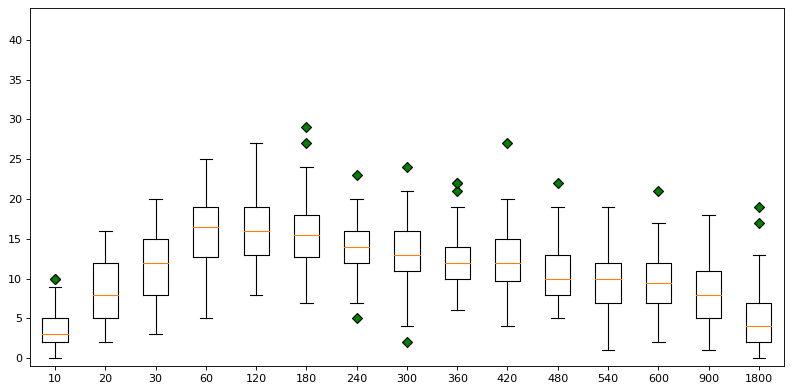

In [10]:
simple_boxplot(exp_dict_persistent, 'completedareas_groupsize0.75_regions_persistent')

### Studio per ogni tipo di area

In [16]:
timeout = -1

red_dict = {}
blue_dict = {}
mixed_dict = {}

for timeout_folder in natsorted(os.listdir(os.path.join(results_folder_persistent))):
    
    print(colored("\n\nTimeout folder:"+timeout_folder, 'green'))
    parameters = timeout_folder.split("_")
    
    for param in parameters:
        if param.startswith("timeout"):
            timeout = int(param.split("#")[-1]) * 10
            # print("\ttimeout:",timeout)

    if timeout == -1 :
        print(colored("\tWARNING: wrong timeout folder", 'green'))
        continue
        
    red_array = np.array([])
    blue_array = np.array([])
    mixed_array = np.array([])
    completed_client = np.array([])
    completed_server = np.array([])
    for filename in natsorted(os.listdir(os.path.join(results_folder_persistent, timeout_folder))):
        if filename.endswith("taskLOG_client.tsv"):
            print("\tFilename:",filename)
            empty_c = not os.path.getsize(os.path.join(results_folder_persistent, timeout_folder, filename)) > 0
            if empty_c:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                red_array = np.append(red_array, 0)
                blue_array = np.append(blue_array, 0)
                mixed_array = np.append(mixed_array, 0)
                continue

#                 print("\tPath:", os.path.join(results_folder_brownian, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_persistent, timeout_folder, filename), sep="\t", header=None)
            df.columns =['Completed_t', 'ID', 'Creation_t', 'Completed_t', 'Type', 'Contained']
            completed_client = df.loc[:,"Type"].values
#             print(df)
            print("completed_client: ", completed_client)
            
            
        if filename.endswith("taskLOG_server.tsv"):
            print("\tFilename:",filename)
            empty_s = not os.path.getsize(os.path.join(results_folder_persistent, timeout_folder, filename)) > 0
            if not empty_c and empty_s:
                sys.exit("ERROR!!!! client not empty, while empty server file at:" + filename)
            if empty_s:
                print(colored("\tWARNING, empty file at:" + filename, 'red'))
                continue

#                 print("\tPath:", os.path.join(results_folder_brownian, experiment, timeout_folder, filename))
            df = pd.read_csv(os.path.join(results_folder_persistent, timeout_folder, filename), sep="\t", header=None)
            df.columns =['Completed_t', 'ID', 'Creation_t', 'Completed_t', 'Type', 'Contained']
            completed_server = df.loc[:,"Type"].values
            
#             print(df)
            print("completed_server: ",completed_server)
            
            
#             break
            
            red_sum = np.sum((completed_server==1) & (completed_client==1))
            blue_sum = np.sum((completed_server==0) & (completed_client==0))
            mixed_sum = np.sum((completed_server==0) & (completed_client==1)) + np.sum((completed_server==1) & (completed_client==0))
            print(colored("red_sum", 'red'), red_sum)
            print(colored("blue_sum", 'blue'), blue_sum)
            print(colored("mixed_sum", 'green'), mixed_sum)
            red_array = np.append(red_array, red_sum)
            blue_array = np.append(blue_array, blue_sum)
            mixed_array = np.append(mixed_array, mixed_sum)

    red_dict[timeout] = red_array
    blue_dict[timeout] = blue_array
    mixed_dict[timeout] = mixed_array
#     break  #evaluate just one folder



Timeout folder:four_regions_2021-05-04_robots#24_timeout#1_redAreas#4_1800seconds
	Filename: seed#1_completed_taskLOG_client.tsv
completed_client:  [0 0 0]
	Filename: seed#1_completed_taskLOG_server.tsv
completed_server:  [0 0 0]
red_sum 0
blue_sum 3
mixed_sum 0
	Filename: seed#2_completed_taskLOG_client.tsv
completed_client:  [0]
	Filename: seed#2_completed_taskLOG_server.tsv
completed_server:  [0]
red_sum 0
blue_sum 1
mixed_sum 0
	Filename: seed#3_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#3_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 0
	Filename: seed#4_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#4_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 0
	Filename: seed#5_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0]
	Filename: seed#5_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0]
red_sum 0
blue_sum 6
mix

completed_client:  [0]
	Filename: seed#79_completed_taskLOG_server.tsv
completed_server:  [0]
red_sum 0
blue_sum 1
mixed_sum 0
	Filename: seed#80_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#80_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 0
	Filename: seed#81_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0]
	Filename: seed#81_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0]
red_sum 0
blue_sum 7
mixed_sum 0
	Filename: seed#82_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0]
	Filename: seed#82_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 0
	Filename: seed#83_completed_taskLOG_client.tsv
completed_client:  [0 0]
	Filename: seed#83_completed_taskLOG_server.tsv
completed_server:  [0 0]
red_sum 0
blue_sum 2
mixed_sum 0
	Filename: seed#84_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0]
	Filename: seed#84_c

completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 12
mixed_sum 0
	Filename: seed#20_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0]
	Filename: seed#20_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0]
red_sum 0
blue_sum 7
mixed_sum 0
	Filename: seed#21_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#21_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 0
	Filename: seed#22_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#22_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 0
	Filename: seed#23_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#23_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0]
red_sum 0
blue_sum 4
mixed_sum 1
	Filename: seed#24_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#24_

completed_server:  [0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 0
	Filename: seed#60_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#60_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 0
	Filename: seed#61_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#61_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 0
	Filename: seed#62_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0]
	Filename: seed#62_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0]
red_sum 0
blue_sum 4
mixed_sum 0
	Filename: seed#63_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#63_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 0
	Filename: seed#64_completed_taskLOG_client.tsv
completed_client:  [0 0 0]
	Filename: seed#64_completed_taskLOG_server.tsv
completed_

completed_server:  [0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 11
mixed_sum 0
	Filename: seed#100_completed_taskLOG_client.tsv
completed_client:  [0 0 0]
	Filename: seed#100_completed_taskLOG_server.tsv
completed_server:  [0 0 0]
red_sum 0
blue_sum 3
mixed_sum 0
<class 'numpy.ndarray'>


Timeout folder:four_regions_2021-05-04_robots#24_timeout#3_redAreas#4_1800seconds
	Filename: seed#1_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0]
	Filename: seed#1_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0]
red_sum 0
blue_sum 7
mixed_sum 0
	Filename: seed#2_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0]
	Filename: seed#2_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 0
	Filename: seed#3_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#3_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 0
	Filename: see

completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#37_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 0
	Filename: seed#38_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0]
	Filename: seed#38_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 0
	Filename: seed#39_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0]
	Filename: seed#39_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 0
	Filename: seed#40_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#40_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 0
	Filename: seed#41_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#41_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0

completed_client:  [0 0 0 0 0 0 0]
	Filename: seed#75_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 1
	Filename: seed#76_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#76_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 12
mixed_sum 0
	Filename: seed#77_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0]
	Filename: seed#77_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 0
	Filename: seed#78_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0]
	Filename: seed#78_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 10
mixed_sum 0
	Filename: seed#79_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0]
	Filename: seed#79_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0]
red_sum 0
blue_sum 7
mixed_sum 0
	Filename: seed

completed_server:  [0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 10
mixed_sum 0
	Filename: seed#47_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#47_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 23
mixed_sum 0
	Filename: seed#48_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0]
	Filename: seed#48_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 0
	Filename: seed#49_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#49_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 1
	Filename: seed#50_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#50_completed_taskLOG_server.tsv
completed_server:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

	Filename: seed#85_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
	Filename: seed#85_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 19
mixed_sum 2
	Filename: seed#86_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#86_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 15
mixed_sum 0
	Filename: seed#87_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0]
	Filename: seed#87_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 10
mixed_sum 0
	Filename: seed#88_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#88_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 15
mixed_sum 0
	Filename: seed#89_completed_taskLOG_client.tsv
completed_client:  [

completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
red_sum 0
blue_sum 20
mixed_sum 4
	Filename: seed#20_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
	Filename: seed#20_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 13
mixed_sum 1
	Filename: seed#21_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
	Filename: seed#21_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1]
red_sum 0
blue_sum 15
mixed_sum 3
	Filename: seed#22_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#22_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 0
	Filename: seed#23_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#23_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 1 0 0 0 0 1]
red_sum 0
b

completed_client:  [0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
	Filename: seed#59_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 4
	Filename: seed#60_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#60_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
red_sum 0
blue_sum 20
mixed_sum 4
	Filename: seed#61_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
	Filename: seed#61_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 1 1 0 0 1 0 0 0 0 0]
red_sum 1
blue_sum 10
mixed_sum 3
	Filename: seed#62_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
	Filename: seed#62_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 15
mixed_sum 2
	Filename: seed#63_completed_taskLOG_client.tsv
completed_client:  [

	Filename: seed#91_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#91_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 11
mixed_sum 0
	Filename: seed#92_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#92_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 15
mixed_sum 1
	Filename: seed#93_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#93_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 23
mixed_sum 2
	Filename: seed#94_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#94_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 17
mixed_sum 1
	Filename: seed#95_completed_tas

	Filename: seed#22_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
	Filename: seed#22_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
red_sum 0
blue_sum 15
mixed_sum 2
	Filename: seed#23_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0]
	Filename: seed#23_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 0
	Filename: seed#24_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
	Filename: seed#24_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0]
red_sum 1
blue_sum 13
mixed_sum 4
	Filename: seed#25_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 0 1 0 0 1]
	Filename: seed#25_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 0 1 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 5
	Filename: seed#26_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 

completed_client:  [0 0 0 0 0 0 0 0 0 1 0 0]
	Filename: seed#58_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 0 1 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 3
	Filename: seed#59_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0]
	Filename: seed#59_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 5
	Filename: seed#60_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#60_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 17
mixed_sum 1
	Filename: seed#61_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 1 0 0 1 0 0]
	Filename: seed#61_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 2
	Filename: seed#62_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
	Filename: seed#6

completed_client:  [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
	Filename: seed#93_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 14
mixed_sum 4
	Filename: seed#94_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
	Filename: seed#94_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 13
mixed_sum 4
	Filename: seed#95_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 1 0 0]
	Filename: seed#95_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 1 0 0 0 0 0]
red_sum 0
blue_sum 11
mixed_sum 2
	Filename: seed#96_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#96_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 1 0 0]
red_sum 0
blue_sum 11
mixed_sum 1
	Filename: seed#97_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#97_complete

completed_server:  [0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0]
red_sum 0
blue_sum 11
mixed_sum 6
	Filename: seed#32_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 1 0 0]
	Filename: seed#32_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 1 0 0 0 0 0 0]
red_sum 0
blue_sum 11
mixed_sum 2
	Filename: seed#33_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 1 0 0 0 0 0 0 1]
	Filename: seed#33_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 1 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 4
	Filename: seed#34_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
	Filename: seed#34_completed_taskLOG_server.tsv
completed_server:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 15
mixed_sum 4
	Filename: seed#35_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 0]
	Filename: seed#35_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 0 0]
red_sum 0
blue_sum 7
mixed_sum 2
	Filename

completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 10
mixed_sum 2
	Filename: seed#70_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0]
	Filename: seed#70_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1]
red_sum 0
blue_sum 12
mixed_sum 6
	Filename: seed#71_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]
	Filename: seed#71_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0]
red_sum 0
blue_sum 12
mixed_sum 5
	Filename: seed#72_completed_taskLOG_client.tsv
completed_client:  [1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0]
	Filename: seed#72_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 10
mixed_sum 7
	Filename: seed#73_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 0 0 1 0 0 0]
	Filename: seed#73_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 1]
red_sum 0
b

completed_server:  [0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0]
red_sum 1
blue_sum 10
mixed_sum 5
	Filename: seed#7_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 1 0 1 0 0 0 0 0]
	Filename: seed#7_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 1 0 0]
red_sum 0
blue_sum 9
mixed_sum 4
	Filename: seed#8_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0]
	Filename: seed#8_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0]
red_sum 2
blue_sum 13
mixed_sum 4
	Filename: seed#9_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 0 0 0 0 0 0 0]
	Filename: seed#9_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 10
mixed_sum 1
	Filename: seed#10_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0]
	Filename: seed#10_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 0
	Filename: seed#11_comple

	Filename: seed#46_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0]
	Filename: seed#46_completed_taskLOG_server.tsv
completed_server:  [0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1]
red_sum 1
blue_sum 12
mixed_sum 5
	Filename: seed#47_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
	Filename: seed#47_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 1 0 0 0 0 0 1 0 0]
red_sum 0
blue_sum 10
mixed_sum 5
	Filename: seed#48_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0]
	Filename: seed#48_completed_taskLOG_server.tsv
completed_server:  [0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
red_sum 1
blue_sum 11
mixed_sum 9
	Filename: seed#49_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#49_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 11
mixed_sum 2
	Filename: seed#50_completed_taskLOG_client.

completed_client:  [0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0]
	Filename: seed#82_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
red_sum 0
blue_sum 13
mixed_sum 7
	Filename: seed#83_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 1 1 0 0 0]
	Filename: seed#83_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 1 0 0 0]
red_sum 1
blue_sum 8
mixed_sum 2
	Filename: seed#84_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0]
	Filename: seed#84_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
red_sum 1
blue_sum 12
mixed_sum 6
	Filename: seed#85_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 1 0 0 0 0 1 0 0]
	Filename: seed#85_completed_taskLOG_server.tsv
completed_server:  [0 0 1 1 0 0 1 0 0 0 0 0 1 0]
red_sum 1
blue_sum 9
mixed_sum 4
	Filename: seed#86_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0]
	Filename: seed#86_

completed_server:  [0 0 0 1 0 0 0 0 1 1 0 0]
red_sum 1
blue_sum 7
mixed_sum 4
	Filename: seed#22_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0]
	Filename: seed#22_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0]
red_sum 2
blue_sum 11
mixed_sum 3
	Filename: seed#23_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 0]
	Filename: seed#23_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 1
	Filename: seed#24_completed_taskLOG_client.tsv
completed_client:  [0 1 0 1 0 0 0 0 1 0 0 0 0 1 0]
	Filename: seed#24_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0]
red_sum 1
blue_sum 10
mixed_sum 4
	Filename: seed#25_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 0]
	Filename: seed#25_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 1 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 3
	Filename: seed#26_completed_taskLOG_client.tsv


completed_server:  [0 0 0 0 0 1 0 0]
red_sum 0
blue_sum 6
mixed_sum 2
	Filename: seed#58_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 1 0 0 1 1 0]
	Filename: seed#58_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 10
mixed_sum 4
	Filename: seed#59_completed_taskLOG_client.tsv
completed_client:  [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#59_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0]
red_sum 0
blue_sum 11
mixed_sum 6
	Filename: seed#60_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0]
	Filename: seed#60_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
red_sum 0
blue_sum 12
mixed_sum 6
	Filename: seed#61_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 0 1 0 0 0 0 0]
	Filename: seed#61_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0 0 0 0 1]
red_sum 1
blue_sum 10
mixed_

completed_client:  [0 0 0 0 0 1 0 0 0 0 1 0]
	Filename: seed#96_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 10
mixed_sum 2
	Filename: seed#97_completed_taskLOG_client.tsv
completed_client:  [0 0 1 1 0 1 1 0 0 0]
	Filename: seed#97_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 1 0 0 0]
red_sum 2
blue_sum 6
mixed_sum 2
	Filename: seed#98_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0]
	Filename: seed#98_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 1
	Filename: seed#99_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 1 1 0 0 0 0 0 1 0]
	Filename: seed#99_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 1 0 1 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 5
	Filename: seed#100_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
	Filename: seed#100_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 1 0 

completed_client:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0]
	Filename: seed#34_completed_taskLOG_server.tsv
completed_server:  [1 0 0 0 0 0 0 0 1 0 0 0 0 1]
red_sum 0
blue_sum 10
mixed_sum 4
	Filename: seed#35_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 1 0 0]
	Filename: seed#35_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 3
	Filename: seed#36_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0]
	Filename: seed#36_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 0 0]
red_sum 0
blue_sum 7
mixed_sum 1
	Filename: seed#37_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 1 0 0 0 0 0 0 0 0 0]
	Filename: seed#37_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 12
mixed_sum 2
	Filename: seed#38_completed_taskLOG_client.tsv
completed_client:  [1 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#38_completed_taskLOG_server.tsv
completed_server:  [1 0 0 0 0 0 1 0

completed_client:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#68_completed_taskLOG_server.tsv
completed_server:  [0 0 1 1 0 0 1 0 1 0 0 1 0 0]
red_sum 0
blue_sum 9
mixed_sum 5
	Filename: seed#69_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 1 1 0 0 0 0 0]
	Filename: seed#69_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0 0 0]
red_sum 1
blue_sum 8
mixed_sum 2
	Filename: seed#70_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1]
	Filename: seed#70_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1]
red_sum 2
blue_sum 11
mixed_sum 4
	Filename: seed#71_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
	Filename: seed#71_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
red_sum 0
blue_sum 12
mixed_sum 3
	Filename: seed#72_completed_taskLOG_client.tsv
completed_client:  [1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]
	Filename: seed#72_completed_ta

completed_server:  [0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0]
red_sum 1
blue_sum 10
mixed_sum 5
	Filename: seed#6_completed_taskLOG_client.tsv
completed_client:  [1 0 0 0 0 0 0 0]
	Filename: seed#6_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 2
	Filename: seed#7_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 1 0 1 1 0]
	Filename: seed#7_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 0 1 0 0]
red_sum 1
blue_sum 6
mixed_sum 3
	Filename: seed#8_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 1 0 0 0]
	Filename: seed#8_completed_taskLOG_server.tsv
completed_server:  [0 1 1 0 0 0 0 0 0 0 0 0]
red_sum 1
blue_sum 9
mixed_sum 2
	Filename: seed#9_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 0 0 0]
	Filename: seed#9_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 1
	Filename: seed#10_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 0 1 0 0 0

completed_client:  [0 0 1 0 0 0 0 0 0 0 0 0]
	Filename: seed#45_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0 0 1 0]
red_sum 0
blue_sum 9
mixed_sum 3
	Filename: seed#46_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1]
	Filename: seed#46_completed_taskLOG_server.tsv
completed_server:  [0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0]
red_sum 1
blue_sum 10
mixed_sum 7
	Filename: seed#47_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 0]
	Filename: seed#47_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 1 0 1 0 0]
red_sum 0
blue_sum 8
mixed_sum 3
	Filename: seed#48_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 1 0 0 0 0]
	Filename: seed#48_completed_taskLOG_server.tsv
completed_server:  [0 1 1 1 0 0 0 0 0]
red_sum 1
blue_sum 5
mixed_sum 3
	Filename: seed#49_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1]
	Filename: seed#49_completed_taskLOG_server.tsv
completed_

completed_client:  [0 0 0 1 0 0 0 0 1 0 0 0]
	Filename: seed#81_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 1 1 0 0 0]
red_sum 1
blue_sum 9
mixed_sum 2
	Filename: seed#82_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0]
	Filename: seed#82_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 1
	Filename: seed#83_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0]
	Filename: seed#83_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 1 0]
red_sum 0
blue_sum 8
mixed_sum 1
	Filename: seed#84_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
	Filename: seed#84_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0]
red_sum 0
blue_sum 11
mixed_sum 7
	Filename: seed#85_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 0 0]
	Filename: seed#85_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 1 0 0 0]
r

completed_server:  [0 0 0 0 1 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 1
	Filename: seed#19_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 1 0 0 0 1 0]
	Filename: seed#19_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 1 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 4
	Filename: seed#20_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 1 1 0 0 0 0 0]
	Filename: seed#20_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 1 0 0 0 0 0 1 0 0]
red_sum 0
blue_sum 8
mixed_sum 5
	Filename: seed#21_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0]
	Filename: seed#21_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 1 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 2
	Filename: seed#22_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 1 0 0 0 1 0 0 0]
	Filename: seed#22_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 1 0 0 0 0 0 0 0]
red_sum 1
blue_sum 9
mixed_sum 3
	Filename: seed#23_completed_taskLOG_client.tsv
completed_cl

completed_client:  [0 0 1 0 1 0 0 0 0 0]
	Filename: seed#54_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 1 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 4
	Filename: seed#55_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 0 0 0 1]
	Filename: seed#55_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 1 0]
red_sum 0
blue_sum 4
mixed_sum 4
	Filename: seed#56_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 1 0 0 0]
	Filename: seed#56_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 2
	Filename: seed#57_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0]
	Filename: seed#57_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1]
red_sum 0
blue_sum 10
mixed_sum 6
	Filename: seed#58_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0]
	Filename: seed#58_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0]
red_sum 0
blue_sum 6


completed_client:  [0 0 0 1 0 0 0 0 1 0 0 0 0]
	Filename: seed#94_completed_taskLOG_server.tsv
completed_server:  [0 1 0 0 0 0 1 0 0 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 4
	Filename: seed#95_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
	Filename: seed#95_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 1 1 0 0 0 0 0 1]
red_sum 0
blue_sum 10
mixed_sum 5
	Filename: seed#96_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 0 0 0 0 1 0 1]
	Filename: seed#96_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0 0 0 0 0 1]
red_sum 1
blue_sum 9
mixed_sum 3
	Filename: seed#97_completed_taskLOG_client.tsv
completed_client:  [0 0 1 1 0 0 0 0 0]
	Filename: seed#97_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 1 0 0 0]
red_sum 1
blue_sum 6
mixed_sum 2
	Filename: seed#98_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 0 0 0 1]
	Filename: seed#98_completed_taskLOG_server.tsv
completed_server:  [0 0 0 

completed_client:  [0 0 0]
	Filename: seed#33_completed_taskLOG_server.tsv
completed_server:  [0 0 0]
red_sum 0
blue_sum 3
mixed_sum 0
	Filename: seed#34_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 1 0 0 0 0]
	Filename: seed#34_completed_taskLOG_server.tsv
completed_server:  [1 0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 8
mixed_sum 2
	Filename: seed#35_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 1 0 0]
	Filename: seed#35_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 3
	Filename: seed#36_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0 0 1]
	Filename: seed#36_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 1 0 0 0 1 1]
red_sum 1
blue_sum 7
mixed_sum 3
	Filename: seed#37_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 0 1 0]
	Filename: seed#37_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 2
	Filename: seed#38_completed_taskLOG_

completed_server:  [0 0 1 0 0 0 0 0 0]
red_sum 0
blue_sum 7
mixed_sum 2
	Filename: seed#74_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 1 0 0 0 0 0 0]
	Filename: seed#74_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 1 0 0 0 0 0 1]
red_sum 1
blue_sum 9
mixed_sum 2
	Filename: seed#75_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 0 1 0]
	Filename: seed#75_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 3
	Filename: seed#76_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 1 1 0 0 1]
	Filename: seed#76_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0 1 0 0 1 0 0 0]
red_sum 1
blue_sum 8
mixed_sum 4
	Filename: seed#77_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0 0 0 0 0]
	Filename: seed#77_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 1 1 0 0]
red_sum 0
blue_sum 5
mixed_sum 4
	Filename: seed#78_completed_taskLOG_client.tsv
completed_client:  [0 0 

completed_server:  [0 0]
red_sum 0
blue_sum 2
mixed_sum 0
	Filename: seed#14_completed_taskLOG_client.tsv
completed_client:  [1 0 1 0 1 1 0 0 1 0 0]
	Filename: seed#14_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 1 1 0 0]
red_sum 1
blue_sum 5
mixed_sum 5
	Filename: seed#15_completed_taskLOG_client.tsv
completed_client:  [0 0 0]
	Filename: seed#15_completed_taskLOG_server.tsv
completed_server:  [0 0 0]
red_sum 0
blue_sum 3
mixed_sum 0
	Filename: seed#16_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 1 1 0 0]
	Filename: seed#16_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 1 0 0]
red_sum 1
blue_sum 10
mixed_sum 1
	Filename: seed#17_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0 1 1 0 1 0]
	Filename: seed#17_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 0 0 0 0 1 0]
red_sum 1
blue_sum 6
mixed_sum 4
	Filename: seed#18_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#18_completed_t

completed_server:  [0 1 0 0 0 1 1 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 5
	Filename: seed#55_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 0 1]
	Filename: seed#55_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0 1]
red_sum 1
blue_sum 3
mixed_sum 2
	Filename: seed#56_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 0 0 0 0]
	Filename: seed#56_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 9
mixed_sum 0
	Filename: seed#57_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 1 0 0 1 0 0 1 0]
	Filename: seed#57_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0 0 1 1 0 0 0]
red_sum 1
blue_sum 9
mixed_sum 4
	Filename: seed#58_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0 1]
	Filename: seed#58_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 0 0]
red_sum 0
blue_sum 4
mixed_sum 2
	Filename: seed#59_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 1 0 1]
	Filename: seed#59_

completed_client:  [0 0 0 1 0 0 0 0]
	Filename: seed#96_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 0 0]
red_sum 0
blue_sum 6
mixed_sum 2
	Filename: seed#97_completed_taskLOG_client.tsv
completed_client:  [0 0 1 1 0]
	Filename: seed#97_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0]
red_sum 1
blue_sum 3
mixed_sum 1
	Filename: seed#98_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0 0 0]
	Filename: seed#98_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 1
	Filename: seed#99_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 1 1]
	Filename: seed#99_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0 0 0 0]
red_sum 0
blue_sum 5
mixed_sum 3
	Filename: seed#100_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0]
	Filename: seed#100_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0]
red_sum 0
blue_sum 4
mixed_sum 0
<class 'numpy.ndarray'>


Timeout folder:four_regions_2021-05-04_ro

completed_server:  [0 0 0]
red_sum 0
blue_sum 2
mixed_sum 1
	Filename: seed#38_completed_taskLOG_client.tsv
completed_client:  [1 0]
	Filename: seed#38_completed_taskLOG_server.tsv
completed_server:  [1 0]
red_sum 1
blue_sum 1
mixed_sum 0
	Filename: seed#39_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0]
	Filename: seed#39_completed_taskLOG_server.tsv
completed_server:  [1 0 0 0]
red_sum 0
blue_sum 3
mixed_sum 1
	Filename: seed#40_completed_taskLOG_client.tsv
completed_client:  [0 0]
	Filename: seed#40_completed_taskLOG_server.tsv
completed_server:  [0 0]
red_sum 0
blue_sum 2
mixed_sum 0
	Filename: seed#41_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 1 0 0 0 1 0 0 0]
	Filename: seed#41_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 1 0 1 0 0 0 0 1]
red_sum 1
blue_sum 8
mixed_sum 3
	Filename: seed#42_completed_taskLOG_client.tsv
completed_client:  [0 1 0 0]
	Filename: seed#42_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0]
red_sum 0
blue_sum 3
m

completed_client:  [0 0 0 1 1]
	Filename: seed#78_completed_taskLOG_server.tsv
completed_server:  [0 0 1 0 1]
red_sum 1
blue_sum 2
mixed_sum 2
	Filename: seed#79_completed_taskLOG_client.tsv
completed_client:  [1 0 1]
	Filename: seed#79_completed_taskLOG_server.tsv
completed_server:  [0 0 0]
red_sum 0
blue_sum 1
mixed_sum 2
	Filename: seed#80_completed_taskLOG_client.tsv
completed_client:  [0 0 0 0 0]
	Filename: seed#80_completed_taskLOG_server.tsv
completed_server:  [0 0 0 1 0]
red_sum 0
blue_sum 4
mixed_sum 1
	Filename: seed#81_completed_taskLOG_client.tsv
completed_client:  [0 0 0 1 0]
	Filename: seed#81_completed_taskLOG_server.tsv
completed_server:  [0 0 0 0 0]
red_sum 0
blue_sum 4
mixed_sum 1
	Filename: seed#82_completed_taskLOG_client.tsv
completed_client:  [0 0]
	Filename: seed#82_completed_taskLOG_server.tsv
completed_server:  [0 0]
red_sum 0
blue_sum 2
mixed_sum 0
	Filename: seed#83_completed_taskLOG_client.tsv
completed_client:  [0 0 1 0 1 0 0 1 0 1 0 1 0]
	Filename: seed#83

RED {10: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 20: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 30: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0

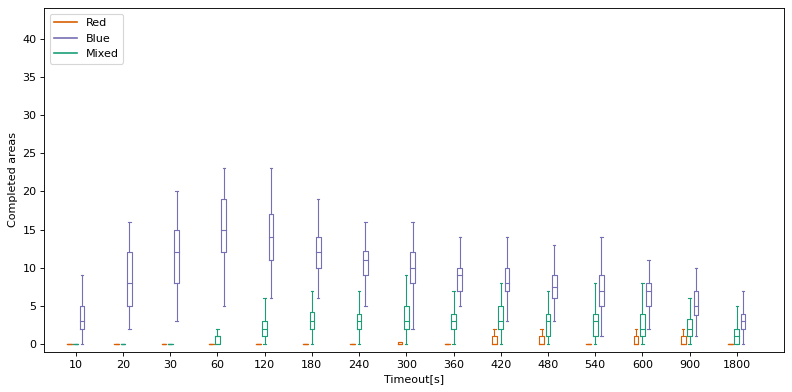

In [15]:
grouped_3_boxplot(red_dict, blue_dict, mixed_dict, 'different_completedareas_groupsize0.75_regions_persistent.png')